In [1]:
#THIS CODE BLOCK PULLS ALL APPLE NEWS INFO FOR 30 DAYS STARTING FROM 2024-12-17
from datetime import datetime, timedelta, date
import requests
import pandas as pd

#STATIC VARIABLES
apiKey = "7f3e0b80d1dc4d6996eef6d6eb5329ff"
q = "Apple"
start_date = "2024-12-17"
num_dates = 30
#source_ids = ['australian-financial-review','axios','bloomberg','business-insider','financial-post', 'fortune', 'reuters', 'the-wall-street-journal']
#sources = ','.join(source_ids)
url = "https://newsapi.org/v2/everything"


#This function inputs a date in the form of 'YYYY-MM-DD' and return a list of the date and next num_dates
def generate_dates(start_date: str, num_dates: int) -> list:
    date = datetime.strptime(start_date, "%Y-%m-%d")
    dates = [(date + timedelta(days=i)).strftime("%Y-%m-%d") for i in range(num_dates)]
    return dates
    
def set_params(date: str) -> dict:
    #apiKey, q, date, and language set by global variables
    params = { 'apiKey': apiKey,
               'q': q,
               'from': date,
               'to': date,
               'language': 'en',
               'page_size': 100,
               #'sources': sources  
             }

    return params

def get_news(url, start_date, num_dates):

    #this variable will store all the headlines from the request
    headlines = []

    #num of dates to grab starting from the start_date 
    dates = generate_dates(start_date, num_dates)

    #go through each date
    for date in dates:

        #set the params-- which is just the date in this case
        params = set_params(date)

        #make the request
        response = requests.get(url=url, params=params) 

        #pull the articles
        articles = response.json()

        #go through each article and create a JSON object of the title, name, url, and pubAt
        try:
            for article in articles['articles']:
                headline = { "title": article['title'],
                             "name": article['source']['name'],
                             "url": article['url'],
                             "publishedAt": article['publishedAt'] }
                headlines.append(headline)
        except: 
            pass
            
    return headlines
    
#headlines = get_news(url, start_date, num_dates)
#df = pd.DataFrame(headlines)
#df.to_json("apple_headlines_30_dates_from_20241217.json", orient="records", indent=4)
   

In [2]:
#THIS CODE BLOCK WILL LOOK AT EACH OF HEADLINES RETRIEVED (IN THE PAST CODE BLOCK) AND DETERMINE WHETHER THE HEADLINE IS RELEVANT
#TO A STOCK TRADER TRADING APPL STOCK
from openai import OpenAI

#STATIC VARIABLES
f = open("OAI_apikey")
api_key = f.read().strip()
f.close()
sys_content = (
    "You are an expert stock trader specializing in market trends, financial analysis, and trading strategies "
    "related to Apple Inc. Provide clear and accurate insights to any queries you receive."
)
client = OpenAI(api_key=api_key)

def query_relevance_gpt4o(headline):

    user_content = (
        "Is the following headline relevant to your work as an expert stock trader focused on Apple Inc.? "
        f"HEADLINE: {headline}. "
        "Respond only with True or False."
    )

    completion = client.chat.completions.create(
        model="gpt-4o",
        store=True,
        messages=[
            {
                "role": "system", 
                "content": sys_content
            },
            {"role": "user", "content": user_content}
        ]
    )

    return {"True": True, "False": False}.get(completion.choices[0].message.content, False)

#df = pd.read_json("apple_headlines_30_dates_from_20241217.json")
#df["relevant"] = [query_relevance_gpt4o(headline) for headline in df.title]

In [3]:
#SAVE TO PREVENT HAVING TO RUN CODE ABOVE AGAIN
#df.to_json("apple_headlines_with_relevance_30_dates_from_20241217.json", orient="records", indent=4)

In [4]:
#THIS CODE BLOCK WILL LOOK AT EACH OF HEADLINES RETRIEVED (IN THE PAST CODE BLOCK) AND 
# DETERMINE THE SENTIMENT/POLARITY
import re
import json

def query_sentiment_gpt4o(headline):

    user_content = (
            "You are a sentiment analysis expert specializing in financial news. Your task is to evaluate "
            "the sentiment of a given headline and return four sentiment scores:"
            "- **`neg` (negative sentiment score):** Between 0 and 1."
            "- **`neu` (neutral sentiment score):** Between 0 and 1."
            "- **`pos` (positive sentiment score):** Between 0 and 1."
            "- **`compound` (overall sentiment score):** Between -1 and 1."
            "The sum of `neg`, `neu`, and `pos` should always equal 1. Use the compound score to reflect "
            "the overall sentiment's strength and direction."
            "Return the result as a dictionary in the following format:"
            "`{'neg': <value>, 'neu': <value>, 'pos': <value>, 'compound': <value>}`"
            "Here are examples of how you should evaluate and format your output:"
            "1. **Input Headline:**"
            "   'I love this product! It works great and is very affordable.'"
            "   **Output:**"
            "   `{'neg': 0.0, 'neu': 0.417, 'pos': 0.583, 'compound': 0.8393}`"
            "2. **Input Headline:**"
            "   'This product is okay. It gets the job done, but could be better.'"
            "   **Output:**"
            "   `{'neg': 0.0, 'neu': 0.476, 'pos': 0.524, 'compound': 0.2732}`"
            "3. **Input Headline:**"
            "   'I hate this product. It doesn't work at all and is a waste of money.'"
            "   **Output:**"
            "   `{'neg': 0.583, 'neu': 0.417, 'pos': 0.0, 'compound': -0.6597}`"
            "Now evaluate the following headline: "
            f"{headline}"
        )

    completion = client.chat.completions.create(
        model="gpt-4o",
        store=True,
        messages=[
            {
                "role": "system", 
                "content": sys_content
            },
            {"role": "user", "content": user_content}
        ]
    )

    return completion.choices[0].message.content
#sentiments = [query_sentiment_gpt4o(headline) for headline in df[df.relevant == True].title]

In [ ]:
#THE SENTIMENT RETURNS FROM OPEN AI NEED TO BE CLEANED
clean_sentiments = []
def extract_between_braces(string):
    try:
        fix = "{" + re.findall(r'\{(.*?)\}', string)[0] + "}"
        fix = fix.replace("'", '"')
        return json.loads(fix)
    except:
        return None
clean_sentiments = [extract_between_braces(sentiment) for sentiment in sentiments]
replacement_value = {'neg': 0, 'neu': 0, 'pos': 0, 'compound': 0}
updated_data = [item if item is not None else replacement_value for item in clean_sentiments]
clean_sentiments_df = pd.DataFrame(updated_data)

#SAVING TO PREVENT HAVING TO RERUN OPEN AI REQUEST FOR SENTIMENT
clean_sentiments_df.to_json("apple_headline_sentiments_30_dates_from_20241217.json", orient="records", indent=4)

In [6]:
#COMBINE THE RELEVANT AND SENTIMENT SCORES FOR OPEN AI 
# GOAL IS TO GET THE AVG POLORITY PER DAY USING OPEN AI's SENTIMENT 

clean_sentiments_df = pd.read_json("apple_headline_sentiments_30_dates_from_20241217.json")
#Only need the date and compound info for relevant headlines
relevant_df = pd.read_json("apple_headlines_with_relevance_30_dates_from_20241217.json")
relevant_df = relevant_df[relevant_df.relevant == True].copy().reset_index().drop(columns=['index', 'title', 'relevant', 'name', 'url'])
df_combined = pd.concat([relevant_df, clean_sentiments_df.compound], axis=1)
df_combined = df_combined[df_combined.compound != 0.0000]

#fix the date and remove the pubAt column
df_combined['Date'] = [d[:10] for d in df_combined.publishedAt]
df_combined = df_combined.drop(columns=['publishedAt'])
df_combined.loc[:, 'Date'] = pd.to_datetime(df_combined['Date'])
df_combined.loc[:, 'compound']= pd.to_numeric(df_combined['compound'])
df_combined = df_combined.sort_values(by='Date')

#calculate average polarity
average_polarity = df_combined.groupby('Date')['compound'].mean()
average_polarity_df = average_polarity.reset_index(name='avg_compound')
average_polarity_df['Date'] = pd.to_datetime(average_polarity_df['Date'])
average_polarity_df = average_polarity_df.sort_values(by="Date")
average_polarity_df.set_index('Date', inplace=True)
#average_polarity_df = average_polarity_df.iloc[1:]

In [7]:
#THIS CODE BLOCK WILL 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

#Per Dr. Elston, the log return is calculated as the natural log 
#of the ratio of the closing price of the current day to the 
#closing price of the previous day.
df = pd.read_csv("Download Data - STOCK_US_XNAS_AAPL.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by="Date")
df['log_return_LABEL'] = np.log(df['Close'] / df['Close'].shift(1))
df.loc[:, 'Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')
df.set_index('Date', inplace=True)
#df = df.iloc[1:]
df['log_return_LABEL'] = df['log_return_LABEL'].shift(-1)
df['close_minus_open'] = [ close - high for (high, close) in zip(df.High, df.Close)]
df = df.iloc[1:]
df = df.iloc[:-1]

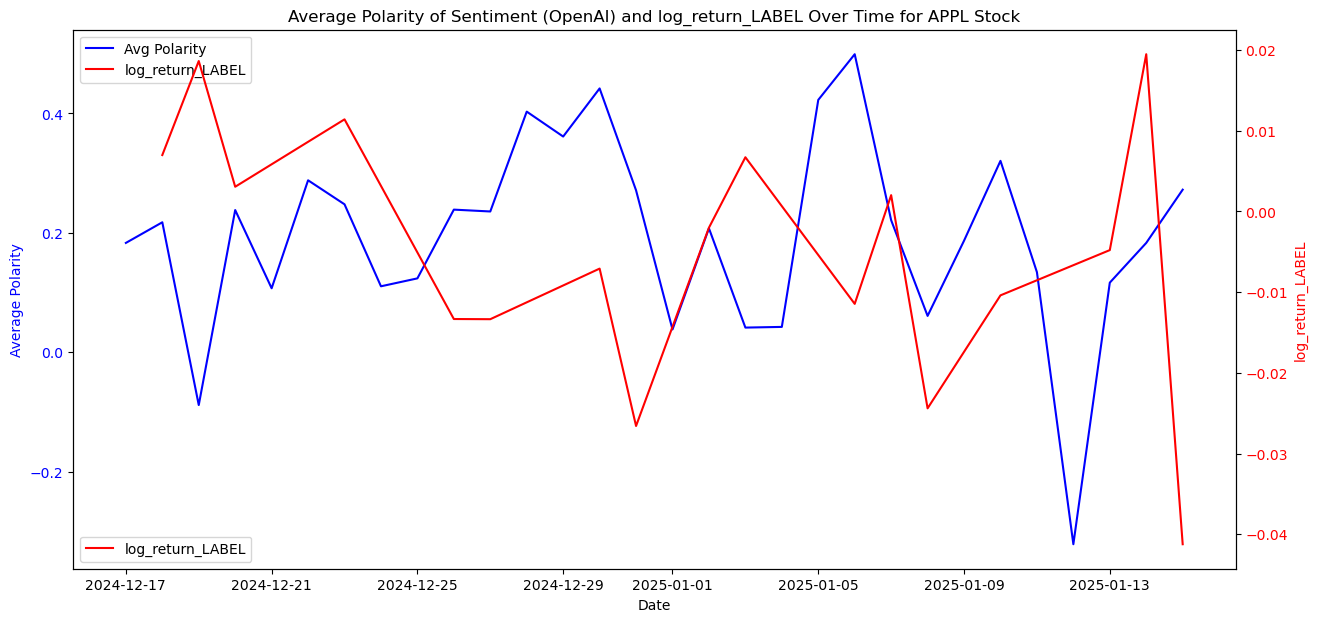

In [8]:
# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot the first dataset on the primary y-axis (left)
sns.lineplot(x=average_polarity_df.index, y=average_polarity_df['avg_compound'], ax=ax1, label='Avg Polarity', color='blue')
ax1.set_ylabel('Average Polarity', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xlabel('Date')

# Create the secondary y-axis (right) and plot the second dataset
ax2 = ax1.twinx()
sns.lineplot(x=df.index, y=df['log_return_LABEL'], ax=ax2, label='log_return_LABEL', color='red')
ax2.set_ylabel('log_return_LABEL', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add a title
plt.title('Average Polarity of Sentiment (OpenAI) and log_return_LABEL Over Time for APPL Stock')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

# Show the plot
plt.show()

In [9]:
#THIS CODE BLOCK WILL LOOK AT EACH OF HEADLINES RETRIEVED (IN THE PAST CODE BLOCK) AND 
# DETERMINE THE SENTIMENT/POLARITY USING VADER!!!!!!!!!!

from nltk.sentiment.vader import SentimentIntensityAnalyzer
headlines_with_relevance_df = pd.read_json("apple_headlines_with_relevance_30_dates_from_20241217.json")
headlines_with_relevance_df = headlines_with_relevance_df[headlines_with_relevance_df.relevant == True]
SIA = SentimentIntensityAnalyzer()
headlines_with_relevance_df['polarity'] = [SIA.polarity_scores(title)['compound'] \
                                           for title in headlines_with_relevance_df.title]

headlines_with_relevance_df = headlines_with_relevance_df[['publishedAt', 'polarity']]
headlines_with_relevance_df['Date'] = [d[:10] for d in headlines_with_relevance_df.publishedAt]
#calculate average polarity
average_polarity = headlines_with_relevance_df.groupby('Date')['polarity'].mean()
average_polarity_df = average_polarity.reset_index(name='avg_compound')
average_polarity_df['Date'] = pd.to_datetime(average_polarity_df['Date'])
average_polarity_df = average_polarity_df.sort_values(by="Date")
average_polarity_df['log_return'] = average_polarity_df['avg_compound'].shift(-1)
average_polarity_df.set_index('Date', inplace=True)

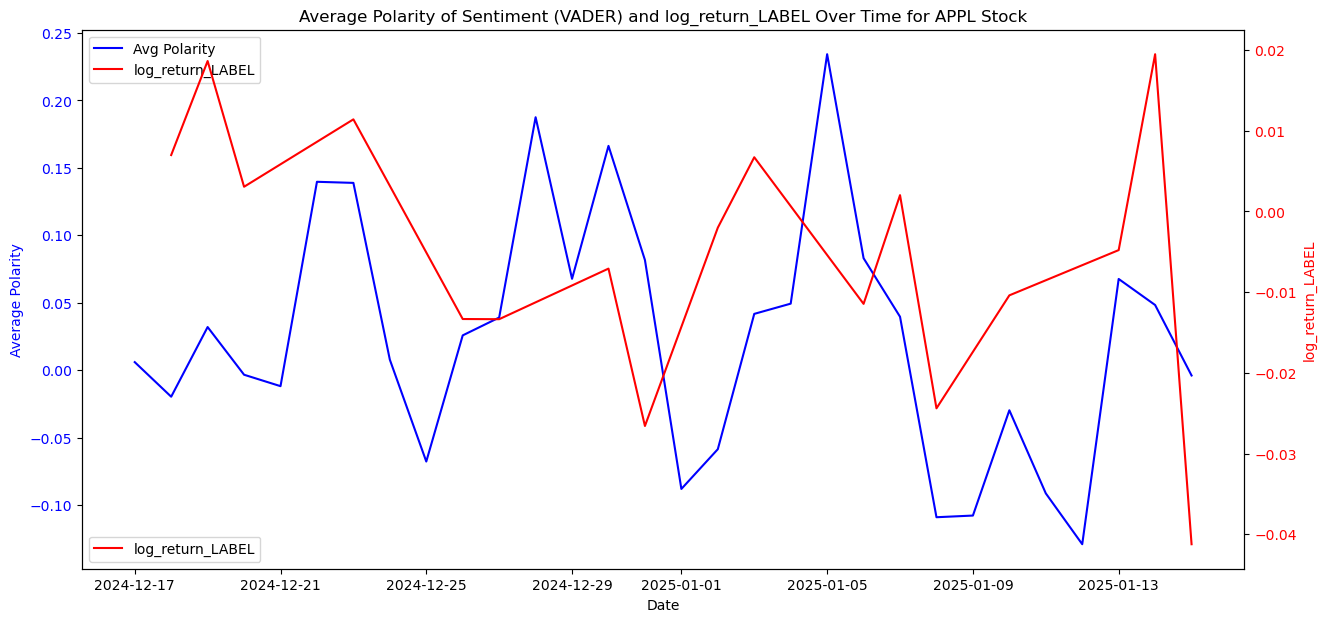

In [10]:
# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(15, 7))

# Plot the first dataset on the primary y-axis (left)
sns.lineplot(x=average_polarity_df.index, y=average_polarity_df['avg_compound'], ax=ax1, label='Avg Polarity', color='blue')
ax1.set_ylabel('Average Polarity', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xlabel('Date')

# Create the secondary y-axis (right) and plot the second dataset
ax2 = ax1.twinx()
sns.lineplot(x=df.index, y=df['log_return_LABEL'], ax=ax2, label='log_return_LABEL', color='red')
ax2.set_ylabel('log_return_LABEL', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add a title
plt.title('Average Polarity of Sentiment (VADER) and log_return_LABEL Over Time for APPL Stock')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

# Show the plot
plt.show()

In [11]:
X = pd.concat([df, average_polarity_df], axis=1)
X = X.dropna(subset=['Open'])
y = X[['log_return_LABEL']]
X = X[['Open','High','Low','Close','Volume','avg_compound']]
X['Volume']= [int(v.replace(",", "")) for v in X.Volume]

In [32]:
#TOY MODEL
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.5, shuffle = False, stratify = None)

# Initialize the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', n_estimators=100)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model performance
rmse = root_mean_squared_error(y_test, y_pred)
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 0.021529674872161318


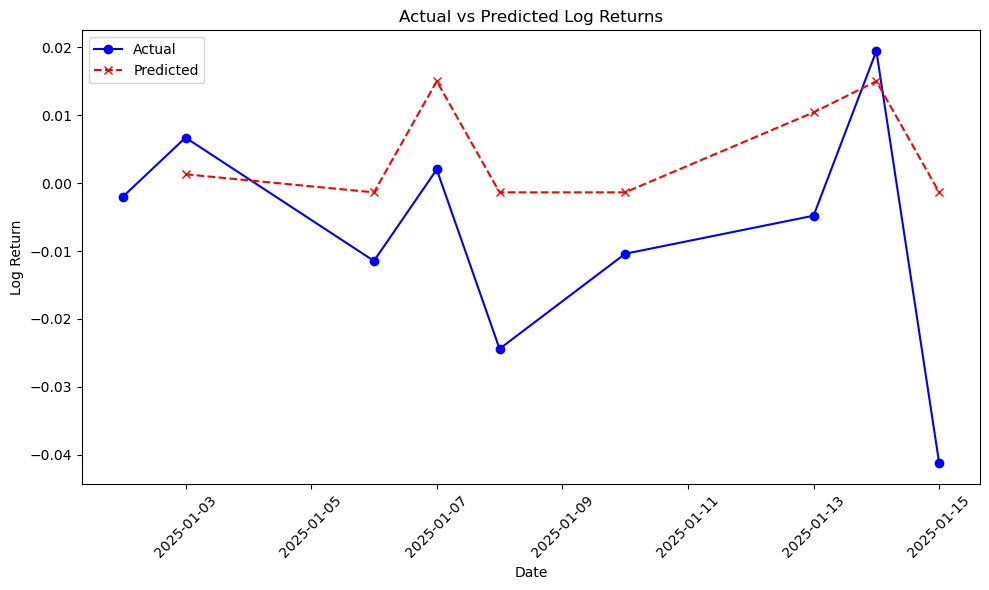

In [37]:
# Plot actual vs predicted log returns
plt.figure(figsize=(10, 6))

# Plot actual values
plt.plot(y_test.index, y_test, label='Actual', color='blue', marker='o')

# Plot predicted values
plt.plot(y_test.index, pd.DataFrame(y_pred, columns=['LogReturn']).shift(1).values, label='Predicted', color='red', linestyle='dashed', marker='x')

# Customize plot
plt.title('Actual vs Predicted Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()

# Rotate the date labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()